# Third-party software computation model example

This example file demonstrates how to build a RunModel object which enables UQpy to execute models in third-party software - see **section 2.3** in the accompanying paper "UQpy: A general purpose Python package and development environment for uncertainty quantification". 

The files necessary to run this example are:
1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus. 

## Description of the model

## The script:

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.RunModel import *
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np

calling_directory = os.getcwd()
t = time.time()

### Building the model:

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

#### Create the model object

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py',
                            var_names=var_names, ntasks=1, model_dir='SFE_Example')
print('Example: Created the model object.')

Example: Created the model object.


### Running the analysis

The model is executed at two points in the input parameter space.

In [4]:
# Running simulations using the previously defined model object and samples
sample_points = np.atleast_2d([[240, 250e6], [440, 220e6]])
abaqus_sfe_model.run(samples=sample_points)

Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.


### Saving the results to a pkl file

In [5]:
# The output from each analysis is the difference between the maximum allowable displacement and the 
# maximum displacement of the midpoint of the beam.
qois = abaqus_sfe_model.qoi_list

# Save the samples and the qois in a dictionary called results with keys 'inputs' and 'outputs'
results = {'inputs': sample_points, 'outputs': qois}

# Pickle the results dictionary in the current directory. The basename and extension of the desired pickle file:
res_basename = 'RunModel_results'
res_extension = '.pkl'

# Create a new results file with a larger index than any existing results files with the same name in the current
# directory.
res_file_list = glob.glob(res_basename + '_???' + res_extension)
if len(res_file_list) == 0:
    res_file_name = res_basename + '_000' + res_extension
else:
    max_number = max(res_file_list).split('.')[0].split('_')[-1]
    res_file_name = res_basename + '_%03d' % (int(max_number) + 1) + res_extension

res_file_name = os.path.join(calling_directory, res_file_name)
# Save the results to this new file.
with open(res_file_name, 'wb') as f:
    pickle.dump(results, f)
print('Saved the results to ' + res_file_name)

Saved the results to C:\Users\Aakash\Reliability\AbaqusExample\RunModel_results_000.pkl


### Plotting the results

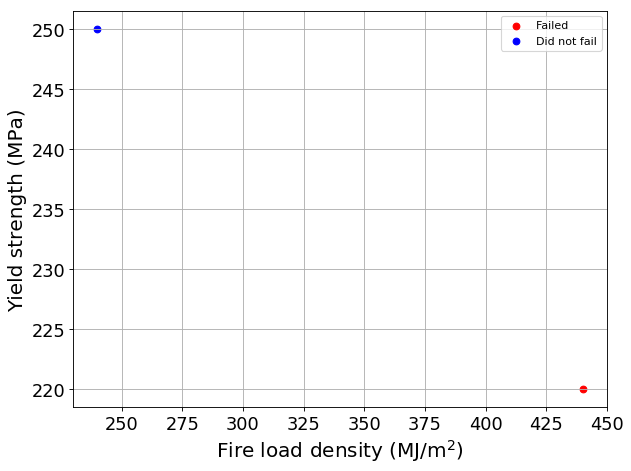

Probability of failure using 2 samples:  0.500000


In [6]:
# Load the results from the latest pickle dump.
with open(res_file_name, 'rb') as f:
    results = pickle.load(f)

# Use the values loaded from pickle file.
sample_points = results['inputs']
Y = np.array(results['outputs'])

x = sample_points[:, 0]
y = sample_points[:, 1]

# 2D plot showing success or failure
fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p3 = plt.scatter(x[Y < 0], y[Y < 0] * 1e-6, color='Red', label='Failed')
p4 = plt.scatter(x[Y >= 0], y[Y >= 0] * 1e-6, color='Blue', label='Did not fail')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Fire load density (MJ/m$^2$)', FontSize=18)
plt.ylabel('Yield strength (MPa)', FontSize=18)
plt.legend()
plt.tight_layout()
plt.savefig('FireExample.pdf')
plt.show()
    
# Compute probability of failure
probability_of_failure = len(Y[Y < 0])/len(Y)
print('Probability of failure using %d samples: % 0.6f' % (len(Y), probability_of_failure))